# Demo of RtDeep

We define a simple network using RtDeep with microcircuits.

2 kinds of tasks:
- learn to adapt the backward weights to propagate GN targets <<< this notebook
- learn to reproduce output of a teacher network.

The model uses real time dynamics with Euler integration, LE, dendritic error propagation and a phased implementation of DTP-DRL.

## Definitions

In [1]:
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=12,family='serif')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from microcircuit import *
import sys
# import pandas as pd


#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport microcircuit

# Learn Gauss-Newton target propagation in small net

We run a net with layers [2-3-2].

We train the backwards weights to solve the auto-encoding problem $g(f(\breve{u}_i^P)) = \breve{u}_i^P$. In order to do so, we inject noise $\xi_i$ of order $u^P_i$ into the apical dendrite and apply the learning rule

\begin{align}
\dot{B^\mathrm{PP}_i} \propto -[B^\mathrm{PP}_i \widehat{r}^P_L - \xi_i]\, \widehat{r}^P_L
\end{align}

The noise is also scaled with a factor $\epsilon$ which measures how well $g(f(\breve{u}_i^P))$ aligns with $\breve{u}_i^P$,

\begin{align}
\epsilon \equiv \frac{1}{2} \big[1-\cos(B^\mathrm{PP}_i \, r^P_L, \breve{u}_i^P)\big]
\end{align}

## Setup

In [735]:
# simulation settings

dt     = 1e-3          # in ms
dtxi   = 10 * dt       # time constant of noise sampling
tausyn = 1 * dtxi      # time constant of low-pass filter on synaptic updates of BPP
Tpres  = 1/dt * dt     # present images for 1 ms
taueps = 10 * Tpres    # time constant of low-pass filter on epsilon
Tbw    = 1 * Tpres     # time scale of phases for backward weight learning
images = 50
epochs = 10

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * uP
noise_scale = [0.2]

np.random.seed(98723)
# np.random.seed(325551)
# np.random.seed(6128736)

# Init model: weights, voltages

layers = [2, 3, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [5000.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1) # we init in SPS
eta_PI = [200.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [0e-5]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively
    # BPP_init.append(np.linalg.pinv(WPP_init[i]))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))
    
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(images, layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

# instantiate the model

mc1 = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=False,
                         gate_regularizer=False, noise_mode='uP_adaptive', model='DTPDRL',
                         activation=logistic, layers=layers,
                         uP_init=uP_init, uI_init=uI_init,
                         WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
                         gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
                         eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP, 
                         noise_deg=45, taueps=10*Tpres)

mc1.set_self_predicting_state()

Let's check how well the backwards matrix aligns with the pseudoinverse of the forward weights (note: this is not a perfect test, as it ignores the activations):

In [736]:
cos_sim(mc1.BPP[-1], np.linalg.pinv(mc1.WPP[-1]))

-0.15675765738821967

## Simulation

We first simulate the net in the currently intialised state. It should learn to propagate the correct targets to the hidden layer. Forward weights are frozen.

After a certain accuracy is reached (here: angle between $g(f(\breve{u}_i^P))$ and $\breve{u}_i^P$ < 45 deg), epsilon is set to zero, and no noise is injected anymore.
In a setting where forward weights are learnt in parallel, it is only in this stage that they would be learnt correctly, as otherwise, noise corrupts the learning signal $v^\mathrm{api}$.

In [737]:
# pre-training to settle voltages -- if we don't do this, weights learn incorrectly due to the incorrect voltages in the beginning
for i in range(int(Tpres/dt)):
    mc1.evolve_system(r0=r0_random[i], learn_weights=False, learn_bw_weights=False)

In [738]:
mc1.init_record(rec_per_steps=1000, rec_WPP=False, rec_WIP=False, rec_BPP=True, rec_BPI=True, rec_rI_breve=False, rec_rP_breve=False, rec_rP_breve_HI=False, rec_vapi=False, rec_vapi_noise=True, rec_epsilon=False, rec_noise=True, rec_epsilon_LO=True)

for j in range(epochs):
    print(f'working on epoch {j}')
    for i in range(len(r0_random)):
        mc1.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
        # mc1.set_self_predicting_state()

working on epoch 0
working on epoch 1
working on epoch 2
working on epoch 3
working on epoch 4
working on epoch 5
working on epoch 6
working on epoch 7
working on epoch 8
working on epoch 9


Now, we change the weights $W^\mathrm{PP}$ from the hidden to output layer, emulating a learning of forward weights. Therefore, the backward weights need to adapt again, which tests if $\epsilon$ is succesful at 'reactivating' noise injection.

In [739]:
cos_sim(mc1.BPP[-1], np.linalg.pinv(mc1.WPP[-1]))

0.897000961111296

In [740]:
# change fw weights
np.random.seed(325551)
    
mc1.set_weights(WPP=[mc1.WPP[0], np.random.uniform(1, 2, size=(layers[-1], layers[-2]))])

In [741]:
cos_sim(mc1.BPP[-1], np.linalg.pinv(mc1.WPP[-1]))

0.40751055700684113

In [742]:
for j in range(epochs):
    print(f'working on epoch {j}')
    for i in range(len(r0_random)):
        mc1.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
    # mc1.set_self_predicting_state()

working on epoch 0
working on epoch 1
working on epoch 2
working on epoch 3
working on epoch 4
working on epoch 5
working on epoch 6
working on epoch 7
working on epoch 8
working on epoch 9


## Evaluation

In [732]:
# we can plot some voltages here

# fig = plt.figure()
# for i in range(len(mc1.vapi_time_series[0][0])):
#     vec = [vec[0][i] for vec in mc1.vapi_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("vapi layer 1")
# plt.show()

# fig = plt.figure()
# vapi_in = []
# for j in range(len(mc1.rP_breve_time_series)):
#         vapi_in.append(mc1.BPP_time_series[j][-1] @ mc1.rP_breve_time_series[j][-1] + mc1.BPI_time_series[j][-1] @ mc1.rI_breve_time_series[j][-1])
# for i in range(len(vapi_in[0])):
#     vec = [vec[i] for vec in vapi_in]
#     plt.plot(np.array(vec).ravel())
# plt.title("vapi pre-noise injection layer 1")
# plt.show()

# fig = plt.figure()
# for i in range(len(mc1.rP_breve_time_series[0][0])):
#     vec = [vec[0][i] for vec in mc1.rP_breve_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("rPbreve layer 1")
# plt.show()

# fig = plt.figure()
# for i in range(len(mc1.rP_breve_time_series[0][1])):
#     vec = [vec[1][i] for vec in mc1.rP_breve_time_series]
#     plt.plot(np.array(vec).ravel())

#     vec = [vec[0][i] for vec in mc1.rI_breve_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("rPbreve/rIbreve layer 2")
# plt.show()

# fig = plt.figure()
# for i in range(len(mc1.rP_breve_time_series[0][1])):
#     vec = [vec[1][i] for vec in mc1.rP_breve_HI_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("rPbreveHI in layer 2")
# plt.show()

Let's look at how $\epsilon$ aka $\cos(B^\mathrm{PP}_i \, r^P_L, \breve{u}_i^P)$ behaves as we learn:

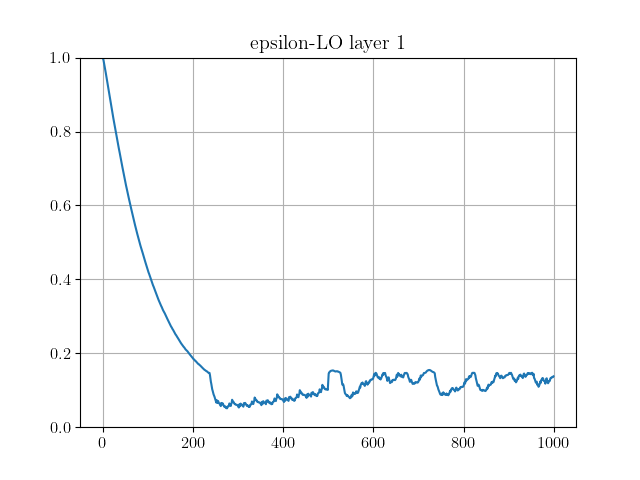

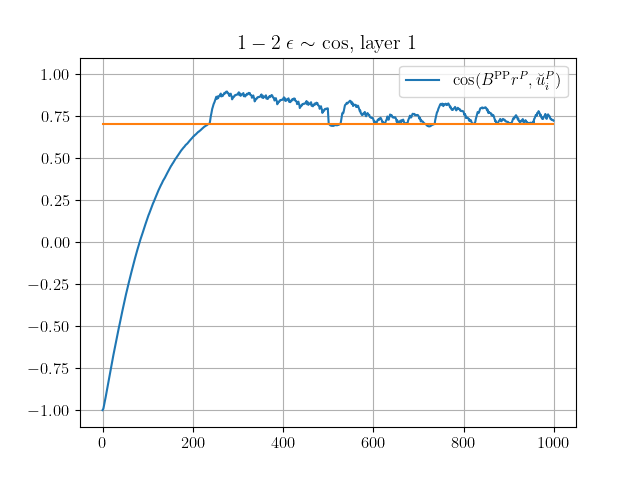

In [743]:
fig = plt.figure()
plt.plot(np.array(mc1.epsilon_LO_time_series).ravel())
# plt.plot(moving_average(np.array(mc1.epsilon_time_series).ravel(), 100))
plt.title("epsilon-LO layer 1")
# plt.yscale("log")
plt.grid()
plt.ylim(0,1)
plt.show()

fig = plt.figure()
# plt.plot(1-2*np.array(mc1.epsilon_time_series).ravel())
# plt.plot(mc1.cos_WPPpinv_BPP[0], label="$\cos(B, W^T)$")
# plt.plot(moving_average(1-2*np.array(mc1.epsilon_time_series).ravel(), 1000), label="$\\cos(B^\\mathrm{PP}\\widehat{r}^P, \\xi)$")
plt.plot(1-2*np.array(mc1.epsilon_LO_time_series).ravel(), label="$\\cos(B^\\mathrm{PP}r^P, \\breve{u}_i^P)$")
plt.plot([np.cos(mc1.noise_deg * np.pi/180) for vec in np.array(mc1.epsilon_LO_time_series).ravel()])
plt.title("$1 - 2 \;\\epsilon \sim$ cos, layer 1")
# plt.yscale("log")
plt.legend()
plt.grid()
plt.ylim(-1.1,1.1)
plt.show()

Investigate noise injection over time:

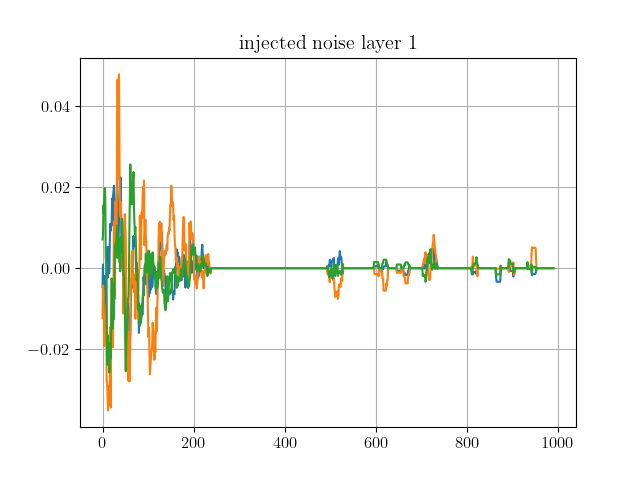

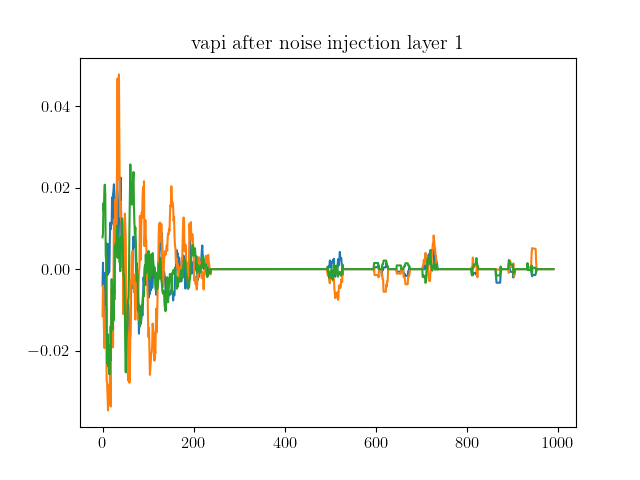

In [744]:
fig = plt.figure()
# plt.plot(np.array([vec[0] for vec in mc1.noise_time_series]))
for i in range(len(mc1.noise_time_series[0][0])):
    plt.plot(moving_average(np.array([vec[0][i] for vec in mc1.noise_time_series]), 10))
plt.title("injected noise layer 1")
plt.grid()
plt.show()

fig = plt.figure()
for i in range(len(mc1.vapi_noise_time_series[0][0])):
    vec = [vec[0][i] for vec in mc1.vapi_noise_time_series]
    plt.plot(moving_average(np.array(vec), 10))
plt.title("vapi after noise injection layer 1")
plt.show()

We also check if the self-predicting state has been learnt correctly:

In [682]:
STEPS = 1

mc1.cos_BPI_BPP = []
for i in range(len(mc1.BPI_time_series[0])):
    mc1.cos_BPI_BPP.append(np.array([
        cos_sim(mc1.BPI_time_series[j][i], -mc1.BPP_time_series[j][i]) for j in range(0, len(mc1.BPI_time_series), STEPS)
                           ]))
    
# mc1.cos_WIP_WPP = []
# for i in range(len(mc1.WIP_time_series[0])):
#     mc1.cos_WIP_WPP.append(np.array([
#         cos_sim(mc1.WIP_time_series[j][i], mc1.WPP_time_series[j][i+1]) for j in range(0, len(mc1.WIP_time_series), STEPS)
#                            ]))
    
# mc1.cos_WPPpinv_BPP = []
# for i in range(len(mc1.BPP_time_series[0])):
#     mc1.cos_WPPpinv_BPP.append(np.array([
#         cos_sim(mc1.BPP_time_series[j][i], np.linalg.pinv(mc1.WPP[i+1])) for j in range(0, len(mc1.BPP_time_series), STEPS)
#                            ]))

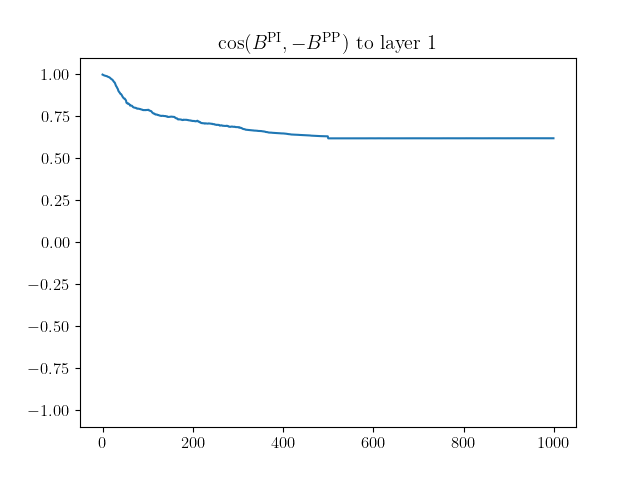

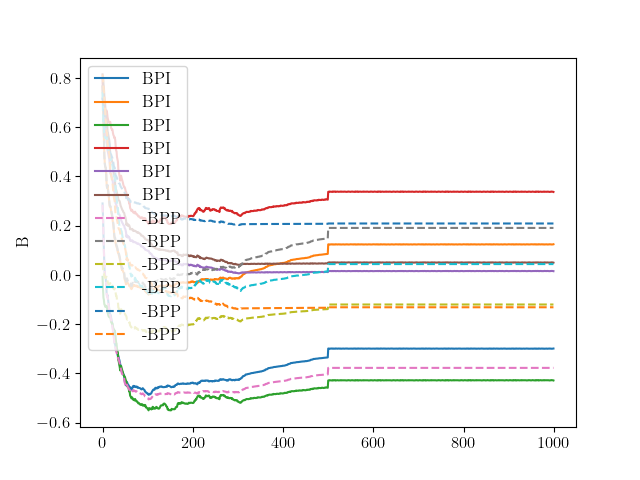

In [683]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_BPI_BPP[i])
    plt.yscale('linear')
    # label = '10 dt'
    # plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([BPI[i].ravel() for BPI in mc1.BPI_time_series], label="BPI")
    ax.plot([-BPP[i].ravel() for BPP in mc1.BPP_time_series], label="-BPP", ls='--')
    plt.yscale('linear')
    # label = 'dt'
    # plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

In [234]:
# for i in range(len(layers[1:-1])):
#     fig, ax = plt.subplots()
#     ax.plot(mc1.cos_WIP_WPP[i])
#     plt.yscale('linear')
#     label = '10 dt'
#     plt.xlabel(label)
#     plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
#     plt.ylim(-1.1,1.1)
#     plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()

To test the alignment, we sample a bunch of potentials, send them to the output layer and back construct the cosine similarity:

In [ ]:
# mc1.cos_reconst = []

# for i in range(len(mc1.BPP_time_series)):

#     arr = []
#     for k in range(100):
#         data = np.random.uniform(-3,3,size=mc1.layers[1])
#         arr.append(
#             cos_sim(mc1.BPP_time_series[i][-1] @ mc1.activation[-1](mc1.WPP[-1] @ mc1.activation[0](data)), data)
#         )
#     mc1.cos_reconst.append(np.mean(arr))
    
# mc1.cos_reconst = np.array(mc1.cos_reconst)

Plot cos between $B$ and $W^+$, and actual entries (Note: the algorithm only aligns $B$ with $W^+$ multiplied with a constant set by the conductances)

In [402]:
# fig, ax = plt.subplots()
# ax.plot(mc1.cos_reconst)
# plt.yscale('linear')
# # label = '10 dt'
# # plt.xlabel(label)
# plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^+)$ to layer ' + str(i+1))
# plt.grid()
# plt.ylim(-1.1,1.1)
# plt.show()